In [1]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
import matplotlib.pyplot as plt
import itertools
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [2]:
def generate_loss(gs, states):
    def weighted_loss(x, y):
        return torch.sum(abs(torch.tensor(gs.full()[states, :])) ** 2 * (x - y) ** 2)
    return weighted_loss
def rfft(x):
    return np.fft.rfft(x)[1:]

In [3]:
hinf12 = j1j2_functions.J1J2_hamiltonian(12, 0, 1)
ginf12 = hinf12.eigenstates()[1][0]

In [4]:
def manual_sr(x, N, shift=0):
    return sum(x[:, (i + shift) % N] + x[:, (i + 1 + shift) % N] for i in range(0, N, 4))
def count_inf_magnetization(state):
    if state == 0: return 0
    return sum(((state >> n) & 1) + ((state >> (n + 1)) & 1) for n in range(0, int(np.log2(state)) + 1, 4))

In [11]:
N=12
states, signs = utils.get_nonzero_states(N, ginf12, 1e-10)
statesinf12 = states
input = utils.generate_input_samples(N, states)
reim_input = []
for x in input: 
    reims = []
    ft = rfft(x)
    for c in ft:
        reims.append(c.real)
        reims.append(c.imag)
    reim_input.append(reims)
reim_input = torch.tensor(reim_input)
print(reim_input.shape)
msr_label = torch.tensor([count_inf_magnetization(s) for s in states]).reshape(-1, 1)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(msr_label.shape, sign_label.shape)
msr_dataset_inf = {'train_input':reim_input, 'train_label':msr_label, 'test_input':reim_input, 'test_label':msr_label}
sign_dataset_inf = {'train_input':reim_input, 'train_label':sign_label, 'test_input':reim_input, 'test_label':sign_label}

torch.Size([400, 12])
torch.Size([400, 1]) torch.Size([400, 1])


In [9]:
sign_model_inf = kan.KAN(width=[12, 12, 1])
sign_model_inf.fit(sign_dataset_inf, lamb=1e-3, steps=50, loss_fn = generate_loss(ginf12, statesinf12));

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 2.33e-03 | test_loss: 2.68e-03 | reg: 3.97e+00 | : 100%|█| 50/50 [00:32<00:00,  1.54it

saving model version 0.1


In [12]:
sign_model_inf.prune().width

saving model version 0.2


[[12, 0], [1, 0], [1, 0]]

In [13]:
sign_model_inf = sign_model_inf.prune()
sign_model_inf.fit(sign_dataset_inf, lamb=1e-3, steps=50, loss_fn = generate_loss(ginf12, statesinf12));

saving model version 0.2


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 1.27e-03 | test_loss: 1.35e-03 | reg: 5.69e+00 | : 100%|█| 50/50 [00:11<00:00,  4.24it

saving model version 0.3


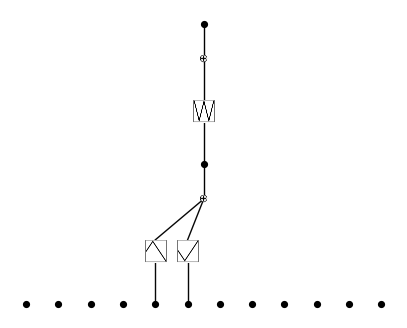

In [14]:
sign_model_inf.plot()

In [18]:
J2 = 0.6024
gs_mid = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_{J2}')
states_mid, signs = utils.get_nonzero_states(N, gs_mid, 1e-10)
input = utils.generate_input_samples(N, states_mid)
reim_input = []
for x in input: 
    reims = []
    ft = rfft(x)
    for c in ft:
        reims.append(c.real)
        reims.append(c.imag)
    reim_input.append(reims)
reim_input = torch.tensor(reim_input)
print(reim_input.shape)
msr_label = torch.tensor([count_inf_magnetization(s) for s in states_mid]).reshape(-1, 1)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(msr_label.shape, sign_label.shape)
msr_dataset_mid = {'train_input':reim_input, 'train_label':msr_label, 'test_input':reim_input, 'test_label':msr_label}
sign_dataset_mid = {'train_input':reim_input, 'train_label':sign_label, 'test_input':reim_input, 'test_label':sign_label}

torch.Size([924, 12])
torch.Size([924, 1]) torch.Size([924, 1])


[1.]


(array([774.,  48.,  24.,  12.,   2.,   0.,  48.,  12.,   0.,   4.]),
 array([6.05955035e-09, 1.48394541e-03, 2.96788475e-03, 4.45182410e-03,
        5.93576344e-03, 7.41970279e-03, 8.90364213e-03, 1.03875815e-02,
        1.18715208e-02, 1.33554602e-02, 1.48393995e-02]),
 <BarContainer object of 10 artists>)

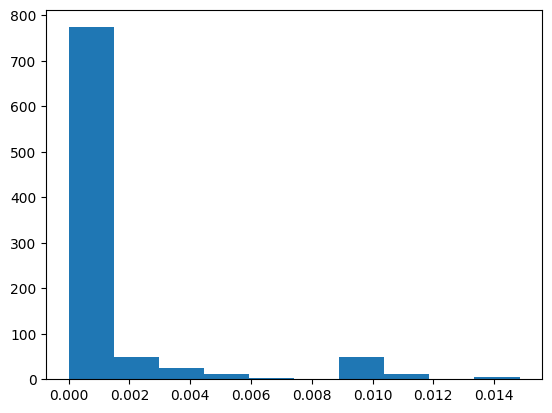

In [24]:
print(sum(abs(gs_mid[states_mid, :]) ** 2))
plt.hist(abs(gs_mid[states_mid, :]) ** 2)

In [25]:
sign_mid_kan = kan.KAN(width=[N, N, N, N, 1])
num_steps=200
results = sign_mid_kan.fit(sign_dataset_mid, lamb=0, steps=num_steps, loss_fn = generate_loss(gs_mid, states_mid));

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.47e-01 | test_loss: 9.24e-01 | reg: 1.14e+02 | : 100%|█| 200/200 [05:48<00:00,  1.74

saving model version 0.1


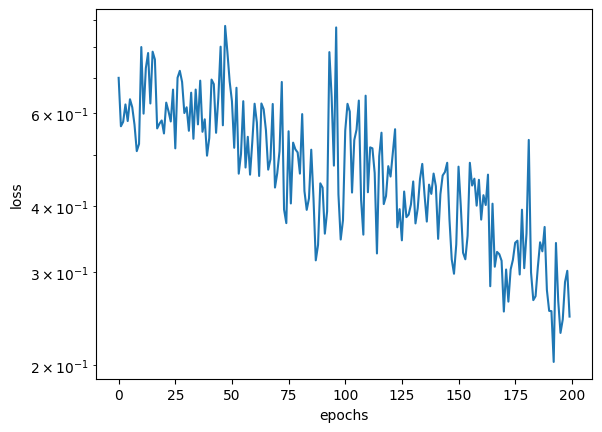

In [26]:
plt.plot(np.arange(num_steps), results['train_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')

In [29]:
print(torch.sqrt(((sign_mid_kan(reim_input).round() - sign_dataset_mid['train_label'])**2).mean()).item())

0.8508971333503723
